## 1. Installation

In [1]:
import sys
!{sys.executable} -m pip uninstall -y glcr
!{sys.executable} -m pip install '..'

Uninstalling glcr-1.1:
  Successfully uninstalled glcr-1.1
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Processing /home/giuseppe/git/ddna/lcs_module
  Running setup.py bdist_wheel for glcr ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-0yc6vk43/wheels/49/b9/38/953ac34c264e3aba4a952ede71c58958f369de1794e3a3ce1d
Successfully built glcr
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


---
## 2. Imports and utils

In [2]:
import numpy as np
import glcr
import os, re

def unicode_to_ascii(array):
    def f(item):
        return str(item)+'\0'
    def v(x):
        return np.vectorize(f)(x)
    return v(array).astype('S')

def purge(dir, pattern):
    for f in os.listdir(dir):
        if re.search(pattern+'*', f):
            os.remove(os.path.join(dir, f))
            
class verbosity:
    TEST = 0           # No result produced
    IN_MEMORY = 1      # Returns the columns lcs and num_words
    FILE = 2           # Returns 0 and saves a .mat file (lcs, num_words, begin, end) and a .gsa (i, wordindex)
    FILE_EXTENDED = 3  # Returns 0 and saves a .mat file (lcs, num_words, begin, end, sequence) and a .gsa (i, wordindex)

dir = '/tmp'
file = 'glcr_cache'
out_file = dir + '/' + file

---
## 3. Compute LCS
#### From numpy array

In [3]:
purge(dir, file)

alphabet = [chr(i) for i in range(48, 51)]
np_alphabet = np.array(alphabet, dtype="|S1")
length = 1000
array = np.random.choice(np_alphabet, [length, 1000])
array = [b"".join(array[i]).decode('utf-8') for i in range(length)]
array = unicode_to_ascii(array)

glcr.longest_common_subsequence(array, "", out_file, verbosity.FILE_EXTENDED)

0

In [4]:

from multiprocessing import Process
from glcr import longest_common_subsequence

p = Process(target=longest_common_subsequence, args=(array, '', '/tmp/glcr_cache', verbosity.FILE))
p.start()
p.join()

#### From file

In [51]:
purge(dir, file)

glcr.longest_common_subsequence(None, "input_4000.txt", '/tmp/glcr_cache', verbosity.IN_MEMORY)

array([[(   2, 30)],
       [(   3, 21)],
       [(   3, 21)],
       ...,
       [(4000,  5)],
       [(4000,  5)],
       [(4000,  5)]], dtype=[('num_texts', '<i8'), ('length', '<i8')])

---
## 4. Benchmark LCS module

In [37]:
import glcr
import pandas as pd
import numpy as np
import timeit

SEQ_LEN = range(1000, 4000, 1000)
NO_SEQ = range(1000, 4000, 1000)
alphabet = [chr(i) for i in range(48,51)]
np_alphabet = np.array(alphabet, dtype="|S1")

cols = ['sequence_len', 'no_sequences', 'ex_time']
res = pd.DataFrame(columns=cols)
for l in SEQ_LEN:
    for n in NO_SEQ:
        codes = np.random.choice(np_alphabet, [l, n])
        codes = [b"".join(codes[i]).decode('utf-8') for i in range(l)]
        codes = unicode_to_ascii(codes)
        t = timeit.timeit('glcr.longest_common_subsequence(codes, "", "/tmp/glcr_cache_arg", verbosity.TEST)',
                          setup='import glcr', number=1, globals=globals())
        res = res.append(pd.DataFrame([[l, n, t]], columns=cols), ignore_index=True)
print(res)

  sequence_len no_sequences    ex_time
0         1000         1000  17.850813
1         1000         2000  17.437781
2         1000         3000  17.145650
3         2000         1000  29.753640
4         2000         2000  32.323347
5         2000         3000  35.124691
6         3000         1000  46.054476
7         3000         2000  59.730591
8         3000         3000  61.635164


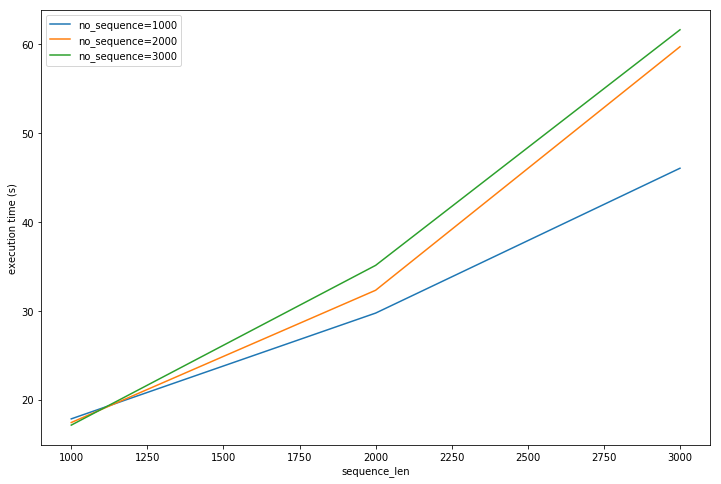

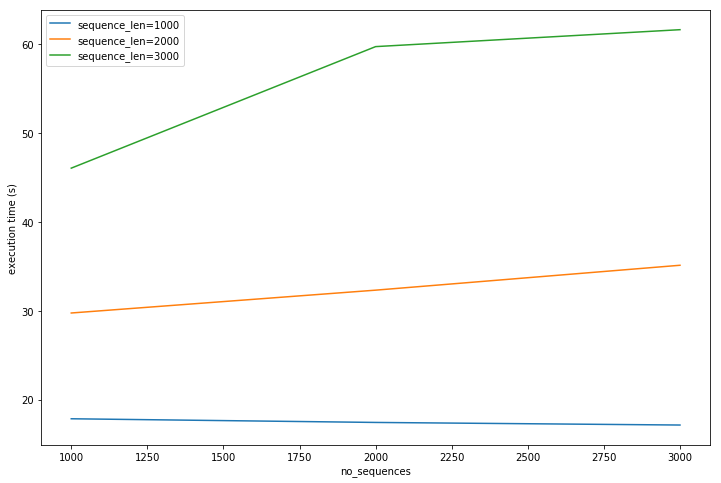

In [38]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

glen = res.groupby('no_sequences')
for g, df in glen:
    plt.plot(df.sequence_len, df.ex_time, label='no_sequence='+str(g))
    plt.xlabel('sequence_len')
    plt.ylabel('execution time (s)')
plt.legend()
plt.show()

glen = res.groupby('sequence_len')
for g, df in glen:
    plt.plot(df.no_sequences, df.ex_time, label='sequence_len='+str(g))
    plt.xlabel('no_sequences')
    plt.ylabel('execution time (s)')
plt.legend()
plt.show()